## Постановка задачи: 
разработать систему предсказания оттока клиентов для компании
Т.к. данные достаточно сложно парсить, был выбран готовый датасет с контекста Data Fusion Contest 2024, где предоставлены данные откуда-то)),
для удобства скачивания весь датасет был выложен на kaggle



In [1]:
import kaggle
import json


import os
try :
    with open("../kaggle.json", "r") as file:
        kaggle_auth_data = json.load(file)
        os.environ['KAGGLE_USERNAME'] = kaggle_auth_data["username"]
        os.environ['KAGGLE_KEY'] = kaggle_auth_data["key"]
except FileNotFoundError:
    print("no_auth_file_was_found")
kaggle.api.authenticate()
kaggle.api.dataset_download_files('krellbob/churn-prediction-from-data-fusin-2024', path="../data_", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/krellbob/churn-prediction-from-data-fusin-2024


- clients.csv - информация о клиентах 
- transactions.csv - ранзакции клиентов банка 
- reports_dates.csv - информация о датах отчетов 
- train.csv - данные о таргетах  

## Препроцессинг данных

In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv("../data_/train.csv")

In [3]:
train_data.head()

,user_id,target,time
0,3,0,77
1,13,0,86
2,37,0,89
3,41,0,57
4,42,0,84


In [4]:
clients = pd.read_csv('../data_/clients.csv')

In [5]:
clients.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age
0,3,2,ОТ 101 ДО 500,0,3
1,9,1,БОЛЕЕ 1001,0,3
2,13,6,ОТ 501 ДО 1000,0,2
3,37,5,БОЛЕЕ 1001,0,2
4,41,1,ОТ 101 ДО 500,0,2


In [6]:
report_dates = pd.read_csv("../data_/report_dates.csv", parse_dates=['report_dt'])

In [7]:
transactions = pd.read_csv("../data_/transactions.csv", parse_dates=["transaction_dttm"])

In [8]:
transactions = transactions.sort_values("transaction_dttm").reset_index(drop=True)

In [9]:
transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,124092,1,1,-437.722809,2021-10-20 09:00:00
1,198674,7,1,-1421.831177,2021-10-20 09:00:03
2,209115,0,1,46684.066406,2021-10-20 09:00:05
3,447095,1,1,-94.699913,2021-10-20 09:00:18
4,348,8,1,-838.885559,2021-10-20 09:00:35
...,...,...,...,...,...
13075018,510219,4,1,-75.810562,2023-03-20 20:58:54
13075019,490168,1,1,-523.368469,2023-03-20 20:59:03
13075020,27159,79,1,-687.029541,2023-03-20 20:59:16
13075021,311184,155,1,-1358.584229,2023-03-20 20:59:42


In [10]:
sample_data = pd.read_csv("../data_/sample_submit_naive.csv")

In [11]:
sample_data

,user_id,predict
0,9,-3.184396
1,61,-2.623560
2,62,-2.840654
3,80,-3.269438
4,88,-2.068500
...,...,...
31995,561362,-2.438619
31996,561419,-2.438619
31997,561895,-2.437339
31998,561908,-2.437339


In [12]:
sample_data['target'] = -1

In [13]:
sample_data

,user_id,predict,target
0,9,-3.184396,-1
1,61,-2.623560,-1
2,62,-2.840654,-1
3,80,-3.269438,-1
4,88,-2.068500,-1
...,...,...,...
31995,561362,-2.438619,-1
31996,561419,-2.438619,-1
31997,561895,-2.437339,-1
31998,561908,-2.437339,-1


In [14]:
train_data = pd.concat([train_data, sample_data])

In [15]:
train_data

,user_id,target,time,predict
0,3,0,77.0,NaN
1,13,0,86.0,NaN
2,37,0,89.0,NaN
3,41,0,57.0,NaN
4,42,0,84.0,NaN
...,...,...,...,...
31995,561362,-1,NaN,-2.438619
31996,561419,-1,NaN,-2.438619
31997,561895,-1,NaN,-2.437339
31998,561908,-1,NaN,-2.437339


In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
train_data = train_data.merge(clients, how="left", on="user_id")

In [18]:
train_data.head()

,user_id,target,time,predict,report,employee_count_nm,bankemplstatus,customer_age
0,3,0,77.0,NaN,2,ОТ 101 ДО 500,0,3
1,13,0,86.0,NaN,6,ОТ 501 ДО 1000,0,2
2,37,0,89.0,NaN,5,БОЛЕЕ 1001,0,2
3,41,0,57.0,NaN,1,ОТ 101 ДО 500,0,2
4,42,0,84.0,NaN,12,ДО 10,0,3


<Axes: >

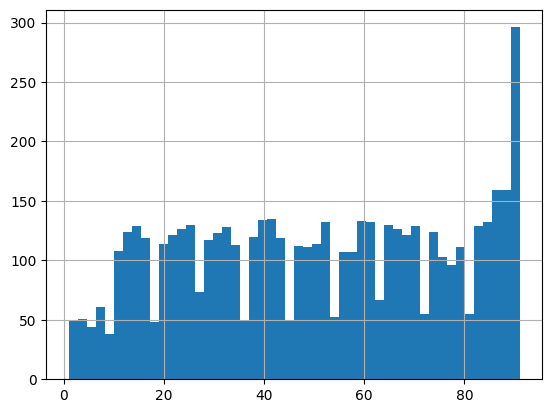

In [21]:
train_data.loc[train_data['target'] == 1,'time'].hist(bins=50)

<Axes: >

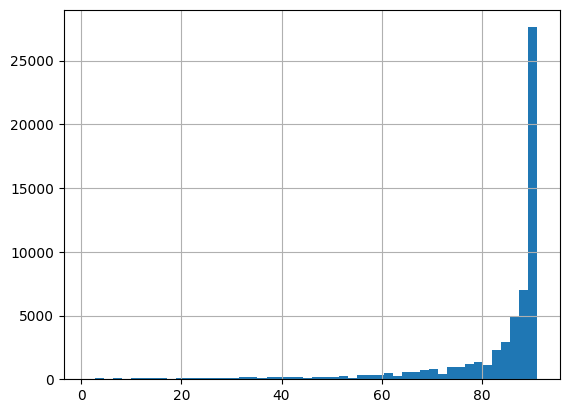

In [22]:
train_data.loc[train_data['target'] == 0,'time'].hist(bins=50)

In [24]:
codes = transactions["mcc_code"].value_counts()

In [25]:
filtered_codes = [code for code in codes if code >= 15]

In [26]:
len(filtered_codes)

281

In [27]:
transactions

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,124092,1,1,-437.722809,2021-10-20 09:00:00
1,198674,7,1,-1421.831177,2021-10-20 09:00:03
2,209115,0,1,46684.066406,2021-10-20 09:00:05
3,447095,1,1,-94.699913,2021-10-20 09:00:18
4,348,8,1,-838.885559,2021-10-20 09:00:35
...,...,...,...,...,...
13075018,510219,4,1,-75.810562,2023-03-20 20:58:54
13075019,490168,1,1,-523.368469,2023-03-20 20:59:03
13075020,27159,79,1,-687.029541,2023-03-20 20:59:16
13075021,311184,155,1,-1358.584229,2023-03-20 20:59:42


In [28]:
codes_table = transactions[transactions.mcc_code.isin(filtered_codes)].pivot_table(
    index = "user_id",
    values=["transaction_amt"],
    columns=["mcc_code"],
    aggfunc=["count", "median", "sum"]
).fillna(0)

In [29]:
codes_table.head()

count                                               ...  \
         transaction_amt                                               ...   
mcc_code             15   16   17   18   22   23   26   28   29   31   ...   
user_id                                                                ...   
3                    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
9                    4.0  0.0  0.0  1.0  0.0  3.0  0.0  0.0  0.0  2.0  ...   
37                   2.0  1.0  0.0  1.0  5.0  0.0  0.0  7.0  0.0  0.0  ...   
41                   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
42                   3.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...   

                     sum                                               
         transaction_amt                                               
mcc_code             246  249  264  266  276  296  318  338  364  412  
user_id                                                                
3                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
9                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
37                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
41                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
42                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 201 columns]

In [31]:
agg_transactions = (
    transactions
    .groupby("user_id")
    .agg(
        transaction_count=("transaction_amt", "count"),
        transaction_sum=("transaction_amt", "sum"),
        transaction_mean=("transaction_amt", "mean"),
        transaction_median=("transaction_amt", "median"),
        transaction_std=("transaction_amt", "std")
    )
    .reset_index()
)

In [32]:
agg_transactions

,user_id,transaction_count,transaction_sum,transaction_mean,transaction_median,transaction_std
0,3,11,13706.416641,1246.037876,4549.455078,60860.880477
1,9,90,-323434.666813,-3593.718520,-840.509674,11797.055119
2,13,22,-124717.379150,-5668.971780,-10529.004883,23507.953991
3,37,315,-331859.599463,-1053.522538,-236.420776,3913.114835
4,41,16,-108586.614166,-6786.663385,-6328.293701,5251.737982
...,...,...,...,...,...,...
95995,562043,37,-29581.256115,-799.493409,-239.170517,2136.038913
95996,562205,151,-40491.908630,-268.158335,-147.305283,590.682233
95997,562312,56,-18537.821270,-331.032523,-271.973526,309.587795
95998,562721,85,-164004.761685,-1929.467785,-399.343048,4172.623511


In [33]:
mcc_features = (
    transactions[transactions.mcc_code.isin(filtered_codes)]
    .pivot_table(
        index="user_id",
        columns="mcc_code",
        values="transaction_amt",
        aggfunc=["count", "sum", "median"]
    )
    .fillna(0)
)

mcc_features.columns = [f"{agg}_{mcc}" for agg, mcc in mcc_features.columns]
mcc_features.reset_index(inplace=True)

In [34]:
mcc_features

,user_id,count_15,count_16,count_17,count_18,count_22,count_23,count_26,count_28,count_29,...,median_246,median_249,median_264,median_266,median_276,median_296,median_318,median_338,median_364,median_412
0,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,4.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,37,2.0,1.0,0.0,1.0,5.0,0.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,41,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,42,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81080,562043,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81081,562205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81082,562312,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81083,562721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
data = clients.merge(agg_transactions, on="user_id", how="left")
data.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age,transaction_count,transaction_sum,transaction_mean,transaction_median,transaction_std
0,3,2,ОТ 101 ДО 500,0,3,11,13706.416641,1246.037876,4549.455078,60860.880477
1,9,1,БОЛЕЕ 1001,0,3,90,-323434.666813,-3593.718520,-840.509674,11797.055119
2,13,6,ОТ 501 ДО 1000,0,2,22,-124717.379150,-5668.971780,-10529.004883,23507.953991
3,37,5,БОЛЕЕ 1001,0,2,315,-331859.599463,-1053.522538,-236.420776,3913.114835
4,41,1,ОТ 101 ДО 500,0,2,16,-108586.614166,-6786.663385,-6328.293701,5251.737982


In [36]:
data["employee_count_nm"] = LabelEncoder().fit_transform(data["employee_count_nm"].fillna("no_data"))

In [37]:
data

,user_id,report,employee_count_nm,bankemplstatus,customer_age,transaction_count,transaction_sum,transaction_mean,transaction_median,transaction_std
0,3,2,4,0,3,11,13706.416641,1246.037876,4549.455078,60860.880477
1,9,1,1,0,3,90,-323434.666813,-3593.718520,-840.509674,11797.055119
2,13,6,8,0,2,22,-124717.379150,-5668.971780,-10529.004883,23507.953991
3,37,5,1,0,2,315,-331859.599463,-1053.522538,-236.420776,3913.114835
4,41,1,4,0,2,16,-108586.614166,-6786.663385,-6328.293701,5251.737982
...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,0,0,2,37,-29581.256115,-799.493409,-239.170517,2136.038913
95996,562205,12,0,0,1,151,-40491.908630,-268.158335,-147.305283,590.682233
95997,562312,12,0,0,0,56,-18537.821270,-331.032523,-271.973526,309.587795
95998,562721,12,0,0,2,85,-164004.761685,-1929.467785,-399.343048,4172.623511


In [38]:
data = data.merge(mcc_features, on="user_id", how="left")

In [39]:
data

,user_id,report,employee_count_nm,bankemplstatus,customer_age,transaction_count,transaction_sum,transaction_mean,transaction_median,transaction_std,...,median_246,median_249,median_264,median_266,median_276,median_296,median_318,median_338,median_364,median_412
0,3,2,4,0,3,11,13706.416641,1246.037876,4549.455078,60860.880477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,1,1,0,3,90,-323434.666813,-3593.718520,-840.509674,11797.055119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13,6,8,0,2,22,-124717.379150,-5668.971780,-10529.004883,23507.953991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37,5,1,0,2,315,-331859.599463,-1053.522538,-236.420776,3913.114835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41,1,4,0,2,16,-108586.614166,-6786.663385,-6328.293701,5251.737982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,0,0,2,37,-29581.256115,-799.493409,-239.170517,2136.038913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95996,562205,12,0,0,1,151,-40491.908630,-268.158335,-147.305283,590.682233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95997,562312,12,0,0,0,56,-18537.821270,-331.032523,-271.973526,309.587795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95998,562721,12,0,0,2,85,-164004.761685,-1929.467785,-399.343048,4172.623511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
data = data.merge(sample_data, on="user_id", how="left")

In [41]:
data = data.fillna(0)

In [42]:
data

,user_id,report,employee_count_nm,bankemplstatus,customer_age,transaction_count,transaction_sum,transaction_mean,transaction_median,transaction_std,...,median_264,median_266,median_276,median_296,median_318,median_338,median_364,median_412,predict,target
0,3,2,4,0,3,11,13706.416641,1246.037876,4549.455078,60860.880477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,9,1,1,0,3,90,-323434.666813,-3593.718520,-840.509674,11797.055119,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.184396,-1.0
2,13,6,8,0,2,22,-124717.379150,-5668.971780,-10529.004883,23507.953991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,37,5,1,0,2,315,-331859.599463,-1053.522538,-236.420776,3913.114835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,41,1,4,0,2,16,-108586.614166,-6786.663385,-6328.293701,5251.737982,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,562043,12,0,0,2,37,-29581.256115,-799.493409,-239.170517,2136.038913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
95996,562205,12,0,0,1,151,-40491.908630,-268.158335,-147.305283,590.682233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.359733,-1.0
95997,562312,12,0,0,0,56,-18537.821270,-331.032523,-271.973526,309.587795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
95998,562721,12,0,0,2,85,-164004.761685,-1929.467785,-399.343048,4172.623511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [44]:
data.columns

Index(['user_id', 'report', 'employee_count_nm', 'bankemplstatus',
       'customer_age', 'transaction_count', 'transaction_sum',
       'transaction_mean', 'transaction_median', 'transaction_std',
       ...
       'median_264', 'median_266', 'median_276', 'median_296', 'median_318',
       'median_338', 'median_364', 'median_412', 'predict', 'target'],
      dtype='object', length=213)

In [47]:
user_row = data.loc[11]
nonzero_cols = user_row[user_row != 0].index
nonzero_cols

Index(['user_id', 'report', 'employee_count_nm', 'customer_age',
       'transaction_count', 'transaction_sum', 'transaction_mean',
       'transaction_median', 'transaction_std', 'count_15', 'count_28',
       'count_34', 'count_63', 'count_123', 'sum_15', 'sum_28', 'sum_34',
       'sum_63', 'sum_123', 'median_15', 'median_28', 'median_34', 'median_63',
       'median_123'],
      dtype='object')

In [48]:
report_date = transactions["transaction_dttm"].max()

In [50]:
report_date

Timestamp('2023-03-20 20:59:58')

In [51]:
transactions["days_to_report"] = (report_date - transactions["transaction_dttm"]).dt.days

In [52]:
transactions["days_to_report"]

0           516
1           516
2           516
3           516
4           516
           ... 
13075018      0
13075019      0
13075020      0
13075021      0
13075022      0
Name: days_to_report, Length: 13075023, dtype: int64